### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи:
Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

Описание датасета:
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры


### Опробованные варианты:
#### 1) Базовая модель: только исключены показатели с пропусками
*RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123)  
Локальный результат: r2 = 0.7345183880191818  
Kaggle: r2 = 0.72001*

#### 2) Подбор гиперпараметров
*RandomForestRegressor(max_depth=16, n_estimators=175, random_state=123)  
Локальный результат: r2 = 0.7403388280755667  
Kaggle: r2 = 0.73384*

#### 3) Работа с признаками
 - DistrictId заменен медианными значениями цены (Price_median) по каждому району  
*RandomForestRegressor(max_depth=16, n_estimators=175, random_state=123)  
Локальный результат: r2 = 0.7432353600717603  
Kaggle: r2 = 0.73556*
 - Обработка пропусков признака LifeSquare  
*Локальный результат: r2 = 0.7414595607051893  
Kaggle: r2 = 0.73079*  
 - Обработка значений признаков LifeSquare и KitchenSquare, где  LifeSquare > Square и KitchenSquare > Square  
*Локальный результат: r2 = 0.7479298025327008  
Kaggle: r2 = 0.72931*
 - Исключены признаки 'Ecology_3', 'Social_1'  
*Локальный результат: r2 = 0.7485333002741337  
Kaggle: r2 = 0.73213*

Подобранные гиперпараметры:  
'max_depth': 16,  
'n_estimators': 175


In [216]:
import pandas as pd
import numpy as np

In [217]:
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [218]:
import warnings
warnings.filterwarnings('ignore')

In [219]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [220]:
houses_train = pd.read_csv('./train.csv')

In [221]:
houses_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [222]:
houses_train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

Проблема с подбором значений LifeSquare, из-за них r2 уменьшился. Попробуем вычислить коэффициент Square/LifeSquare в зависимости от года постройки дома и от этажности дома (Предполагая что из-за изменения планировок домов со временм может и коэффициент меняться)

In [223]:
# Иcправим аномальные значения признака HouseYear:
houses_train.loc[(houses_train['HouseYear'] == 20052011), ['HouseYear']] = 2011
houses_train.loc[(houses_train['HouseYear'] == 4968), ['HouseYear']] = 1968
houses_train[houses_train['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [224]:
# Проверим аномальные значения LifeSquare:
# найдем значения LifeSquare, превышающие максимальное значение Square и очистим их
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'].max())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366


In [225]:
# Заменяем аномальные значения на None
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'].max()), 'LifeSquare'] = None

In [226]:
# Проверим корректность данных в колонках, описывающих площадь: Square, LifeSquare, KitchenSquare. 
# Признак Square должен быть больше чем LifeSquare и KitchenSquare. 
# LifeSquare > Square
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2.0,59.015896,59.439082,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.142781
9889,12918,23,2.0,51.440463,53.134243,51.0,3,17.0,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.012510
9895,2737,27,3.0,123.430072,125.806981,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
9902,14001,73,1.0,44.098768,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.404161


In [227]:
# LifeSquare > Square
h1 = houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['LifeSquare']]
h2 = houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['Square']]
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['Square']] = h1['LifeSquare']
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square']), ['LifeSquare']] = h2['Square']

In [228]:
# Проверим результат замены, должно быть 0 строк
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [229]:
houses_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,16798.000000
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,209.000000
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,19.000000
Square,10000.0,56.483594,21.565423,2.377248,41.866858,52.633651,66.004634,641.065193
LifeSquare,7886.0,36.255771,20.275124,0.370619,22.769574,32.776846,45.126159,638.163193
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2014.000000
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,117.000000
HouseYear,10000.0,1984.866300,18.412271,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867


In [230]:
# Проверим результат замены, должно быть 0 строк
houses_train.loc[(houses_train['LifeSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [231]:
# Проверим аномальные значения KitchenSquare: 
# найдем значения KitchenSquare, превышающие значение Square и очистим их
# houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square'].max())]
houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
5149,13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.033165
7088,6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960518
8584,14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.556275


In [232]:
# KitchenSquare > Square
houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square']),'KitchenSquare'] = None

In [233]:
# Проверим результат замены, должно быть 0 строк
houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


### Составляем матрицу с коэффициентами

In [234]:
# Матрица коэффициентов median_coeff_by_year_hfloor - отношения Square/LifeSquare и Square/KitchenSquare 
# в зависимости от года постройки и этажности дома
median_coeff_by_year_hfloor = pd.DataFrame()
median_coeff_by_year_hfloor = houses_train.groupby(['HouseYear', 'HouseFloor'])[['Square', 'LifeSquare', 'KitchenSquare']].median().reset_index()
median_coeff_by_year_hfloor

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare
0,1910,9.0,50.808925,15.920343,20.0
1,1912,7.0,151.150660,98.187482,23.0
2,1912,9.0,63.293079,29.389815,18.0
3,1914,6.0,56.172364,28.384213,7.0
4,1916,6.0,102.964468,48.322107,14.0
...,...,...,...,...,...
871,2020,12.0,48.947414,48.947414,5.0
872,2020,17.0,55.911215,43.821379,10.0
873,2020,21.0,83.260743,79.438325,1.0
874,2020,22.0,84.512719,84.512719,1.0


In [235]:
# Нулевые значения KitchenSquare
median_coeff_by_year_hfloor.loc[(median_coeff_by_year_hfloor['KitchenSquare'] == 0)].head()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare
78,1955,4.0,63.600347,49.883184,0.0
265,1977,0.0,59.963701,40.808976,0.0
273,1977,8.0,38.016681,79.439817,0.0
539,2003,27.0,75.276260,45.187294,0.0
604,2008,3.0,212.932361,211.231125,0.0


In [236]:
# Убираем нулевые значения KitchenSquare - заменяем на 0.0001, иначе для них не вычислится коэффициент
median_coeff_by_year_hfloor.loc[(median_coeff_by_year_hfloor['KitchenSquare'] == 0),'KitchenSquare'] = 0.0001

In [237]:
# Проверяем результаты замены, должно быть 0 строк
median_coeff_by_year_hfloor.loc[(median_coeff_by_year_hfloor['KitchenSquare'] == 0)].head()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare


In [238]:
# Матрица коэффициентов median_coeff_by_year - отношения Square/LifeSquare и Square/KitchenSquare 
# в зависимости от года постройки - она нужна для заполнения пустых значений в median_coeff_by_year_hfloor
# median_coeff_by_year = pd.DataFrame()
# median_coeff_by_year = houses_train.groupby(['HouseYear'])[['Square', 'LifeSquare', 'KitchenSquare']].median().reset_index()
# median_coeff_by_year

In [239]:
# Убираем нулевые значения KitchenSquare - заменяем на 0.0001, иначе для них не вычислится коэффициент
# median_coeff_by_year.loc[(median_coeff_by_year['KitchenSquare'] == 0),'KitchenSquare'] = 0.0001

In [240]:
# Проверяем результаты замены, должно быть 0 строк
# median_coeff_by_year.loc[(median_coeff_by_year['KitchenSquare'] == 0)].head()

In [241]:
# Проверим матрицу median_coeff_by_year
# median_coeff_by_year.describe()

In [242]:
# Проверим матрицы median_coeff_by_year_hfloor
median_coeff_by_year_hfloor.describe()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare
count,876.000000,876.000000,876.000000,870.000000,875.000000
mean,1988.727169,13.686073,60.814227,39.342947,7.794287
std,24.787872,9.148344,21.844961,19.142785,3.952948
min,1910.000000,0.000000,24.769705,1.185864,0.000100
25%,1971.000000,8.000000,47.759408,28.952782,6.000000
50%,1995.000000,12.000000,57.146780,35.025402,8.000000
75%,2010.250000,18.000000,68.366283,45.406794,10.000000
max,2020.000000,117.000000,275.645284,233.949309,33.500000


In [243]:
# В матрице median_coeff_by_year_hfloor есть пустые значения LifeSquare и KitchenSquare, вычислим их:
# для LifeSquare = Square * 0.7
# для KitchenSquare = Square * 0.15
median_coeff_by_year_hfloor.loc[(median_coeff_by_year_hfloor['LifeSquare'].isna()), ['LifeSquare']] = median_coeff_by_year_hfloor['Square'] * 0.7
median_coeff_by_year_hfloor.loc[(median_coeff_by_year_hfloor['KitchenSquare'].isna()), ['KitchenSquare']] = median_coeff_by_year_hfloor['Square'] * 0.15

In [244]:
# Проверим пропуски в median_coeff_by_year_hfloor
median_coeff_by_year_hfloor.describe().T

,count,mean,std,min,25%,50%,75%,max
HouseYear,876.0,1988.727169,24.787872,1910.000000,1971.000000,1995.000000,2010.250000,2020.000000
HouseFloor,876.0,13.686073,9.148344,0.000000,8.000000,12.000000,18.000000,117.000000
Square,876.0,60.814227,21.844961,24.769705,47.759408,57.146780,68.366283,275.645284
LifeSquare,876.0,39.372793,19.082117,1.185864,29.052611,35.135228,45.412461,233.949309
KitchenSquare,876.0,7.791909,3.951316,0.000100,6.000000,8.000000,10.000000,33.500000


In [245]:
# Так как пропусков нет - вычисляем коэффициенты
# coeff_s_ls = Square/LifeSquare
# coeff_s_ks = Square/KitchenSquare
median_coeff_by_year_hfloor['coeff_s_ls'] = median_coeff_by_year_hfloor['Square'] / median_coeff_by_year_hfloor['LifeSquare']
median_coeff_by_year_hfloor['coeff_s_ks'] = median_coeff_by_year_hfloor['Square'] / median_coeff_by_year_hfloor['KitchenSquare']
# median_coeff_by_year['coeff_s_ls'] = median_coeff_by_year['Square'] / median_coeff_by_year['LifeSquare']
# median_coeff_by_year['coeff_s_ks'] = median_coeff_by_year['Square'] / median_coeff_by_year['KitchenSquare']

In [246]:
median_coeff_by_year_hfloor.head()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare,coeff_s_ls,coeff_s_ks
0,1910,9.0,50.808925,15.920343,20.0,3.191447,2.540446
1,1912,7.0,151.150660,98.187482,23.0,1.539409,6.571768
2,1912,9.0,63.293079,29.389815,18.0,2.153572,3.516282
3,1914,6.0,56.172364,28.384213,7.0,1.979000,8.024623
4,1916,6.0,102.964468,48.322107,14.0,2.130794,7.354605


In [247]:
# Составим урезанную таблицу, в которую войдут только столбцы 'HouseYear', 'HouseFloor', 'coeff_s_ls', 'coeff_s_ks'
median_coeff_by_year_cut = pd.DataFrame()
median_coeff_by_year_cut = median_coeff_by_year_hfloor[['HouseYear', 'HouseFloor', 'coeff_s_ls', 'coeff_s_ks']]
median_coeff_by_year_cut.head()

,HouseYear,HouseFloor,coeff_s_ls,coeff_s_ks
0,1910,9.0,3.191447,2.540446
1,1912,7.0,1.539409,6.571768
2,1912,9.0,2.153572,3.516282
3,1914,6.0,1.979000,8.024623
4,1916,6.0,2.130794,7.354605


In [248]:
#median_coeff_by_year_cut.loc[median_coeff_by_year_cut['HouseYear'] == 1969]

In [249]:
median_coeff_by_year_cut.describe().T

,count,mean,std,min,25%,50%,75%,max
HouseYear,876.0,1988.727169,24.787872,1910.000000,1971.000000,1995.000000,2010.250000,2.020000e+03
HouseFloor,876.0,13.686073,9.148344,0.000000,8.000000,12.000000,18.000000,1.170000e+02
coeff_s_ls,876.0,1.715792,1.774636,0.478560,1.471381,1.632171,1.794988,4.539778e+01
coeff_s_ks,876.0,12236.289333,109288.418390,1.693191,5.883209,6.905937,9.310498,2.129324e+06


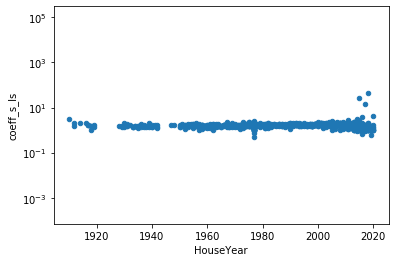

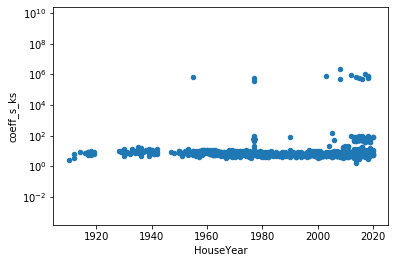

In [250]:
# plt.figure(figsize=(16, 6))

# plt.xlabel('HouseYear')
# plt.ylabel('coeff')
# plt.scatter(median_coeff_by_year_cut['HouseYear'], median_coeff_by_year_cut['coeff_s_ls'], logy=True)
# plt.scatter(median_coeff_by_year_cut['HouseYear'], median_coeff_by_year_cut['coeff_s_ks'])
# plt.legend(['Ecology_1', 'Ecology_2', 'Ecology_3'])
# plt.legend(['Other', 'Price'])
# plt.show()

median_coeff_by_year_cut.plot.scatter(
    'HouseYear', 
    'coeff_s_ls', 
    logy=True)
median_coeff_by_year_cut.plot.scatter(
    'HouseYear', 
    'coeff_s_ks', 
    logy=True)

In [251]:
# Добавляем столбцы с коэффициентами coeff_s_ls и coeff_s_ks в основую таблицу houses_train
houses_train = houses_train.merge(median_coeff_by_year_cut, on=['HouseYear', 'HouseFloor'], how='left')
houses_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,coeff_s_ls,coeff_s_ks
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,NaN,0,11,B,184966.930730,1.562946,7.683844
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.450063,1.539489,8.142525
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.908524,1.640240,4.688681
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.227217,1.369852,58.788418
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2078.0,2,4,B,150226.531644,1.513912,7.188553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,...,46,7960,6,350.0,3,11,B,196684.316040,1.598561,8.737582
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,30,5562,0,NaN,0,5,A,189050.289571,1.869168,6.107398
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,...,2,629,1,NaN,0,0,A,159143.805370,2.075480,70.567808
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,30,5048,9,325.0,2,5,B,181595.339808,1.544116,9.017030


In [252]:
houses_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.483594,21.565423,2.377248,41.866858,52.633651,66.004634,6.410652e+02
LifeSquare,7886.0,36.255771,20.275124,0.370619,22.769574,32.776846,45.126159,6.381632e+02
KitchenSquare,9996.0,5.861545,5.071439,0.000000,1.000000,6.000000,9.000000,1.230000e+02
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,1984.866300,18.412271,1910.000000,1974.000000,1977.000000,2001.000000,2.020000e+03
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [253]:
# Пустые значения признака LifeSquare
houses_train.loc[houses_train['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,coeff_s_ls,coeff_s_ks
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,221244.156664,1.469375,599637.009663
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,...,1,264,0,NaN,0,1,B,229102.795999,1.369852,58.788418
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,127200.026511,1.858640,62.007598
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,...,30,5285,0,645.0,6,6,B,571069.052600,1.469375,599637.009663
25,5073,74,2.0,82.667915,NaN,1.0,16,17.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,244145.827069,1.369852,58.788418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,95529.569405,1.858640,62.007598
9986,2996,1,2.0,64.994245,NaN,1.0,9,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,200332.511658,1.036814,59.953348
9987,15623,23,2.0,55.620092,NaN,0.0,2,4.0,1977,0.034656,...,0,168,0,NaN,0,0,B,115797.553006,1.267702,46.613797
9994,4158,23,2.0,64.864198,NaN,1.0,17,17.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,171323.515653,1.369852,58.788418


In [254]:
# Заполняем пропуски значений признака LifeSquare значением Square/coeff_s_ls
houses_train['LifeSquare'] = houses_train['LifeSquare'].fillna(houses_train['Square'] / houses_train['coeff_s_ls'])

In [255]:
# Проверяем результаты замены, должно быть 0 строк
houses_train.loc[houses_train['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,coeff_s_ls,coeff_s_ks


In [256]:
# Пустые значения признака KitchenSquare
houses_train.loc[houses_train['KitchenSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,coeff_s_ls,coeff_s_ks
1064,14656,62,1.0,47.100719,46.447960,NaN,4,1.0,2014,0.072158,...,2,629,1,NaN,0,0,A,108337.484207,1.555111,62.163097
5149,13703,42,1.0,38.071692,19.723548,NaN,9,10.0,2006,0.158249,...,21,5731,0,NaN,1,0,B,160488.033165,1.930266,6.666667
7088,6569,27,1.0,38.220258,18.716856,NaN,4,17.0,2018,0.011654,...,4,915,0,NaN,0,0,B,99079.960518,1.224415,57.395084
8584,14679,81,1.0,32.276663,19.278394,NaN,6,1.0,1977,0.006076,...,30,5285,0,645.0,6,6,B,105539.556275,1.858640,62.007598


In [257]:
# Заполняем пропуски значений признака KitchenSquare значением Square/coeff_s_ks
houses_train['KitchenSquare'] = houses_train['KitchenSquare'].fillna(houses_train['Square'] / houses_train['coeff_s_ks'])

In [258]:
# Проверяем результаты замены, должно быть 0 строк
houses_train.loc[houses_train['KitchenSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,coeff_s_ls,coeff_s_ks


In [259]:
# houses_train.loc[(houses_train['LifeSquare'] == None), 'LifeSquare'] = houses_train['Square'] / houses_train['coeff_s_ls']

In [260]:
houses_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,8383.407700,4859.019020,0.000000,4169.500000,8394.500000,12592.500000,1.679800e+04
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.483594,21.565423,2.377248,41.866858,52.633651,66.004634,6.410652e+02
LifeSquare,10000.0,37.950371,20.543118,0.370619,24.692572,34.043788,46.573438,6.381632e+02
KitchenSquare,10000.0,5.859965,5.071229,0.000000,1.000000,6.000000,9.000000,1.230000e+02
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,1984.866300,18.412271,1910.000000,1974.000000,1977.000000,2001.000000,2.020000e+03
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01


In [261]:
# Преобразуем категориальный признак Ecology_2, Ecology_3, Shops_2. 
# Все они имеют значения A и B, заменяем на 0 и 1
houses_train.replace({'Ecology_2': {'A': 0, 'B': 1}, 'Ecology_3': {'A': 0, 'B': 1}, 'Shops_2': {'A': 0, 'B': 1}}, inplace=True)

### Замена DitrictID

In [262]:
# Заменим DistrictId медианными значениями цены квадртаного метра по каждому району, 
# составим таблицу median_price_by_dist_id
median_price_by_dist_id = houses_train.groupby('DistrictId')[['Price', 'Square']].median().reset_index()
median_price_by_dist_id['m2_price'] = median_price_by_dist_id['Price'] / median_price_by_dist_id['Square']
median_price_by_dist_id

,DistrictId,Price,Square,m2_price
0,0,165963.054142,48.998792,3387.084585
1,1,183663.443595,60.631137,3029.193475
2,2,208539.501373,47.362676,4403.034587
3,3,169094.013281,47.202193,3582.333846
4,4,278639.482329,53.179791,5239.574588
...,...,...,...,...
200,202,394150.861857,68.245487,5775.486120
201,205,220501.566180,43.226985,5101.016598
202,207,426186.409334,76.780960,5550.678339
203,208,431137.654083,53.860839,8004.659114


In [263]:
# Создади урезанную таблицу, в которую войдут только столбцы DistrictId и m2_price
median_m2_price_by_dist_id = pd.DataFrame()
median_m2_price_by_dist_id = median_price_by_dist_id[['DistrictId', 'm2_price']]
median_m2_price_by_dist_id

,DistrictId,m2_price
0,0,3387.084585
1,1,3029.193475
2,2,4403.034587
3,3,3582.333846
4,4,5239.574588
...,...,...
200,202,5775.486120
201,205,5101.016598
202,207,5550.678339
203,208,8004.659114


In [264]:
# Соединяем таблицу houses_train с соответствующими значениями из таблицы median_m2_price_by_dist_id
# назовем столбец с медианными значениями Price_median
houses_train = houses_train.merge(median_m2_price_by_dist_id, on='DistrictId', how='left')
houses_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,coeff_s_ls,coeff_s_ks,m2_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,1,184966.930730,1.562946,7.683844,4273.980146
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,1,300009.450063,1.539489,8.142525,4395.277115
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,1,220925.908524,1.640240,4.688681,4527.229293
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,1,175616.227217,1.369852,58.788418,2955.306014
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,1,150226.531644,1.513912,7.188553,3942.103724


### Подбор Healthcare_1

In [265]:
houses_train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        9992
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           95
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
coeff_s_ls         856
coeff_s_ks         876
m2_price           205
dtype: int64

In [266]:
def ident_model(train_df):
    model_1 = RandomForestClassifier(max_depth=15)
    train_ = train_df[train_df['Healthcare_1'].notna()][['DistrictId', 'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Healthcare_1']]
    tr, tst = train_test_split(train_, test_size=0.15, random_state=123)
    model_1.fit(tr.drop('Healthcare_1', axis=1), tr['Healthcare_1'])
    pred = model_1.predict(tst.drop('Healthcare_1', axis=1))
    print(accuracy_score(tst['Healthcare_1'], pred))
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Healthcare_1']]
    model_1.fit(train_.drop('Healthcare_1', axis=1), train_['Healthcare_1'])
    pred = model_1.predict(test_.drop('Healthcare_1', axis=1))
    return model_1


def fill_H1(model_1, train_df):
    test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 'Healthcare_1']]
    pred = model_1.predict(test_.drop('Healthcare_1', axis=1))
    return pred

In [267]:
model_1 = ident_model(houses_train)
pred = fill_H1(model_1, houses_train)

1.0


In [268]:
houses_train.loc[houses_train['Healthcare_1'].isna(), 'Healthcare_1'] = pred

In [269]:
houses_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int64  
 11  Ecology_3      10000 non-null  int64  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [307]:
# Разбивка выборки для обучения, при этом удаляем некоторые признаки 
X_train, X_test, y_train, y_test = train_test_split(
    houses_train.set_index('Id').drop(
        ['Price', 
         'DistrictId', 
         'Ecology_3', 
         'Social_1',
         'coeff_s_ls',
         'coeff_s_ks'
         ], axis='columns'), 
    houses_train['Price'], 
    test_size=0.25,
    random_state=123)

In [308]:
# Составляем модель и обучаем ее
model_rfr = RandomForestRegressor(max_depth=16, n_estimators=175, random_state=123)
model_rfr.fit(X_train, y_train)
predict_1 = model_rfr.predict(X_test)
r2(y_test, predict_1)

0.7480544733928685

### Загружаем тестовую выборку

In [309]:
houses_test = pd.read_csv('./test.csv')
houses_test.replace({'Ecology_2': {'A': 0, 'B': 1}, 'Ecology_3': {'A': 0, 'B': 1}, 'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
houses_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,11,2748,1,NaN,0,0,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,1,1,6,1437,3,NaN,0,2,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,23,4583,3,NaN,3,3,1
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,1,1,2,629,1,NaN,0,0,0


In [310]:
houses_train.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        9992
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           95
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
coeff_s_ls         856
coeff_s_ks         876
m2_price           205
dtype: int64

In [311]:
# Заменим DistrictId медианными значениями цены по каждому району, данные берем из таблицы median_m2_price_by_dist_id
houses_test = houses_test.merge(median_m2_price_by_dist_id, on='DistrictId', how='left')

In [312]:
houses_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,16795.000000
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867


In [313]:
# Переименум столбец "Price" в "Price_median"
#houses_test = houses_test.rename(columns={"Price": "Price_median"})

In [314]:
# Заполняем недостающие значения Price медианами
houses_test['m2_price'] = houses_test['m2_price'].fillna(houses_test['m2_price'].median())

In [315]:
# Иcправим аномальные значения признака HouseYear:
houses_test[houses_test['HouseYear'] > 2020]
# их нет

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price


In [316]:
# Проверим аномальные значения LifeSquare:
# найдем значения LifeSquare, превышающие максимальное значение Square и очистим их
houses_test.loc[(houses_train['LifeSquare'] > houses_test['Square'].max())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price
590,753,39,1.0,36.848363,23.560192,9.0,5,12.0,1970,0.428826,1,1,25,5011,8,730.0,0,2,1,3683.980836
1982,12055,74,2.0,61.440716,62.136078,1.0,10,12.0,2017,0.309479,1,1,35,7715,4,990.0,0,6,1,3483.810063
4262,9315,24,2.0,48.649119,29.511021,6.0,6,9.0,1976,0.111627,1,1,50,12238,8,1970.0,2,3,1,5148.994654
4690,12108,9,2.0,54.190543,32.892831,9.0,6,17.0,1992,0.069753,1,1,53,13670,4,NaN,1,11,1,3275.651454


In [317]:
# Заменяем аномальные значения на None
houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square'].max()), 'LifeSquare'] = None

In [318]:
# Проверим корректность данных в колонках, описывающих площадь: Square, LifeSquare, KitchenSquare. 
# Признак Square должен быть больше чем LifeSquare и KitchenSquare. 
# LifeSquare > Square
houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,30,7538,87,4702.0,5,5,1,8361.390680
27,11160,58,1.0,48.610661,48.752502,1.0,4,3.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,2955.306014
39,6624,27,1.0,42.413793,42.434887,10.0,12,17.0,2017,0.011654,1,1,4,915,0,NaN,0,0,1,2654.571480
43,11513,1,1.0,37.484057,40.593036,0.0,4,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,3029.193475
70,1872,30,2.0,52.449057,52.798349,1.0,17,17.0,2016,0.000078,1,1,22,6398,141,1046.0,3,23,1,2685.732205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4927,14686,1,3.0,77.229885,79.958685,1.0,18,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,3029.193475
4951,3711,94,1.0,41.281057,42.392594,10.0,13,13.0,2014,0.282798,1,1,33,8667,2,NaN,0,6,1,4011.718265
4962,5820,94,1.0,33.680382,34.198977,1.0,10,9.0,1972,0.127376,1,1,43,8429,3,NaN,3,9,1,4011.718265
4969,4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015,0.309479,1,1,35,7715,4,990.0,0,6,1,3483.810063


In [319]:
# LifeSquare > Square - меняем местами
h1 = houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square']), ['LifeSquare']]
h2 = houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square']), ['Square']]
houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square']), ['Square']] = h1['LifeSquare']
houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square']), ['LifeSquare']] = h2['Square']

In [320]:
# Проверим результат замены, должно быть 0 строк
houses_test.loc[(houses_test['LifeSquare'] > houses_test['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price


In [321]:
# Проверим аномальные значения KitchenSquare: 
# найдем значения KitchenSquare, превышающие значение Square и очистим их
# houses_train.loc[(houses_train['KitchenSquare'] > houses_train['Square'].max())]
houses_test.loc[(houses_test['KitchenSquare'] > houses_test['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price
1964,14594,11,2.0,42.795304,24.223770,620.0,11,14.0,1972,0.038693,1,1,28,6533,1,1015.0,2,5,1,4193.581864
2424,10662,29,1.0,25.956829,17.251768,33.0,5,5.0,1973,0.069660,1,1,31,6119,4,NaN,1,2,1,4190.624398
3863,3194,29,2.0,43.926987,31.028707,44.0,6,5.0,1964,0.086885,1,1,10,2277,2,1547.0,0,0,1,4190.624398
4555,12640,6,2.0,54.629142,31.486308,97.0,4,17.0,2015,0.243205,1,1,5,1564,0,540.0,0,0,1,2804.269111


In [322]:
# KitchenSquare > Square - приравниваем к None
houses_test.loc[(houses_test['KitchenSquare'] > houses_test['Square']),'KitchenSquare'] = None

In [323]:
# Проверим результат замены, должно быть 0 строк
houses_test.loc[(houses_test['KitchenSquare'] > houses_test['Square'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price


In [324]:
# Матрица коэффициентов median_coeff_by_year_hfloor_test - отношения Square/LifeSquare и Square/KitchenSquare 
# в зависимости от года постройки и этажности дома
median_coeff_by_year_hfloor_test = pd.DataFrame()
median_coeff_by_year_hfloor_test = houses_test.groupby(['HouseYear', 'HouseFloor'])[['Square', 'LifeSquare', 'KitchenSquare']].median().reset_index()
median_coeff_by_year_hfloor_test

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare
0,1908,8.0,157.976101,101.040485,12.0
1,1909,5.0,15.948246,15.948246,12.0
2,1910,5.0,61.400464,38.591813,8.0
3,1911,7.0,52.708494,20.502345,11.0
4,1912,6.0,76.428426,50.344903,11.0
...,...,...,...,...,...
659,2020,11.0,77.057476,70.454039,16.0
660,2020,14.0,64.481854,36.653054,9.0
661,2020,15.0,70.999008,NaN,17.0
662,2020,20.0,66.778360,41.758328,12.5


In [325]:
# Нулевые значения KitchenSquare
median_coeff_by_year_hfloor_test.loc[(median_coeff_by_year_hfloor_test['KitchenSquare'] == 0)].head()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare
190,1977,0.0,59.605443,48.191928,0.0
223,1979,0.0,39.896180,20.358737,0.0
514,2013,0.0,169.901701,169.901701,0.0
556,2015,0.0,77.160328,58.465570,0.0
565,2015,11.0,45.573081,45.490973,0.0


In [326]:
# Убираем нулевые значения KitchenSquare - заменяем на 0.0001, иначе для них не вычислится коэффициент
median_coeff_by_year_hfloor_test.loc[(median_coeff_by_year_hfloor_test['KitchenSquare'] == 0),'KitchenSquare'] = 0.0001

In [327]:
# Проверяем результаты замены, должно быть 0 строк
median_coeff_by_year_hfloor_test.loc[(median_coeff_by_year_hfloor_test['KitchenSquare'] == 0)].head()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare


In [328]:
# Проверим матрицы median_coeff_by_year_hfloor
median_coeff_by_year_hfloor_test.describe()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare
count,664.000000,664.000000,664.000000,656.000000,664.000000
mean,1989.759036,14.048193,60.934174,39.084880,7.629519
std,24.672499,8.570219,19.302053,16.393664,3.940326
min,1908.000000,0.000000,15.948246,2.742068,0.000100
25%,1974.000000,8.000000,46.939941,28.655908,6.000000
50%,1996.000000,14.000000,57.310694,35.566266,8.000000
75%,2011.250000,18.000000,71.609414,46.144312,10.000000
max,2020.000000,99.000000,221.138768,169.901701,40.000000


In [329]:
# В матрице median_coeff_by_year_hfloor_test есть пустые значения LifeSquare и KitchenSquare, вычислим их:
# для LifeSquare = Square * 0.7
# для KitchenSquare = Square * 0.15
median_coeff_by_year_hfloor_test.loc[(median_coeff_by_year_hfloor_test['LifeSquare'].isna()), ['LifeSquare']] = median_coeff_by_year_hfloor_test['Square'] * 0.7
median_coeff_by_year_hfloor_test.loc[(median_coeff_by_year_hfloor_test['KitchenSquare'].isna()), ['KitchenSquare']] = median_coeff_by_year_hfloor_test['Square'] * 0.15

In [330]:
# Проверим матрицы median_coeff_by_year_hfloor_test
median_coeff_by_year_hfloor_test.describe().T

,count,mean,std,min,25%,50%,75%,max
HouseYear,664.0,1989.759036,24.672499,1908.000000,1974.000000,1996.000000,2011.250000,2020.000000
HouseFloor,664.0,14.048193,8.570219,0.000000,8.000000,14.000000,18.000000,99.000000
Square,664.0,60.934174,19.302053,15.948246,46.939941,57.310694,71.609414,221.138768
LifeSquare,664.0,39.140618,16.347159,2.742068,28.677078,35.654345,46.202719,169.901701
KitchenSquare,664.0,7.629519,3.940326,0.000100,6.000000,8.000000,10.000000,40.000000


In [331]:
# Так как пропусков нет - вычисляем коэффициенты
# coeff_s_ls = Square/LifeSquare
# coeff_s_ks = Square/KitchenSquare
median_coeff_by_year_hfloor_test['coeff_s_ls'] = median_coeff_by_year_hfloor_test['Square'] / median_coeff_by_year_hfloor_test['LifeSquare']
median_coeff_by_year_hfloor_test['coeff_s_ks'] = median_coeff_by_year_hfloor_test['Square'] / median_coeff_by_year_hfloor_test['KitchenSquare']

In [332]:
median_coeff_by_year_hfloor_test.head()

,HouseYear,HouseFloor,Square,LifeSquare,KitchenSquare,coeff_s_ls,coeff_s_ks
0,1908,8.0,157.976101,101.040485,12.0,1.563493,13.164675
1,1909,5.0,15.948246,15.948246,12.0,1.000000,1.329021
2,1910,5.0,61.400464,38.591813,8.0,1.591023,7.675058
3,1911,7.0,52.708494,20.502345,11.0,2.570852,4.791681
4,1912,6.0,76.428426,50.344903,11.0,1.518097,6.948039


In [333]:
# Составим урезанную таблицу, в которую войдут только столбцы 'HouseYear', 'HouseFloor', 'coeff_s_ls', 'coeff_s_ks'
median_coeff_by_year_cut_test = pd.DataFrame()
median_coeff_by_year_cut_test = median_coeff_by_year_hfloor_test[['HouseYear', 'HouseFloor', 'coeff_s_ls', 'coeff_s_ks']]
median_coeff_by_year_cut_test.head()

,HouseYear,HouseFloor,coeff_s_ls,coeff_s_ks
0,1908,8.0,1.563493,13.164675
1,1909,5.0,1.000000,1.329021
2,1910,5.0,1.591023,7.675058
3,1911,7.0,2.570852,4.791681
4,1912,6.0,1.518097,6.948039


In [334]:
median_coeff_by_year_cut_test.describe().T

,count,mean,std,min,25%,50%,75%,max
HouseYear,664.0,1989.759036,24.672499,1908.000000,1974.0000,1996.000000,2011.250000,2.020000e+03
HouseFloor,664.0,14.048193,8.570219,0.000000,8.0000,14.000000,18.000000,9.900000e+01
coeff_s_ls,664.0,1.722713,1.361590,0.713231,1.4749,1.642032,1.805416,2.390870e+01
coeff_s_ks,664.0,8743.315097,87562.013431,1.170680,5.9176,7.417456,9.811732,1.699017e+06


In [335]:
# Добавляем столбцы с коэффициентами coeff_s_ls и coeff_s_ks в основую таблицу houses_test
houses_test = houses_test.merge(median_coeff_by_year_cut_test, on=['HouseYear', 'HouseFloor'], how='left')
houses_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price,coeff_s_ls,coeff_s_ks
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,11,2748,1,NaN,0,0,1,2955.306014,1.820293,5.635597
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,6,1437,3,NaN,0,2,1,3483.810063,10.656875,61.795636
2,5480,190,1.0,15.948246,15.948246,12.0,2,5.0,1909,0.000000,...,30,7538,87,4702.0,5,5,1,8361.390680,1.000000,1.329021
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,NaN,3,3,1,3821.027752,1.615830,8.392758
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,NaN,0,0,0,2654.571480,1.176755,53.744339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,36,5992,0,NaN,1,1,1,4193.581864,1.551125,7.980552
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,1,264,0,NaN,0,1,1,3029.193475,1.176755,53.744339
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,...,74,19083,2,NaN,5,15,1,3908.126543,1.608417,7.286979
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,...,2,629,1,NaN,0,0,0,2859.977368,1.236835,596054.433086


In [336]:
houses_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,1.679500e+04
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,2.120000e+02
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,1.700000e+01
Square,5000.0,56.540352,19.091914,1.378543,41.989020,52.930550,66.392939,2.234537e+02
LifeSquare,3958.0,36.091374,17.315095,0.333490,23.091722,32.921472,45.156818,1.699017e+02
KitchenSquare,4996.0,5.822658,4.635047,0.000000,1.000000,6.000000,9.000000,1.120000e+02
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,9.900000e+01
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2.020000e+03
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,5.218671e-01


In [337]:
# Пустые значения признака LifeSquare
houses_test.loc[houses_test['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price,coeff_s_ls,coeff_s_ks
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,6,1437,3,NaN,0,2,1,3483.810063,10.656875,61.795636
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,...,34,7759,0,229.0,1,3,1,4527.229293,1.428571,53.116884
11,3310,6,3.0,84.625350,NaN,1.0,6,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,1,2804.269111,1.365931,62.313276
14,5214,27,1.0,37.555197,NaN,1.0,5,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,1,2654.571480,10.656875,61.795636
21,16688,1,1.0,44.878767,NaN,1.0,1,9.0,1977,0.007122,...,1,264,0,NaN,0,1,1,3029.193475,1.464325,8.551511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1.0,45.542940,NaN,0.0,6,0.0,1977,0.000699,...,14,3369,24,4129.0,0,3,1,5936.654527,1.236835,596054.433086
4985,11732,1,1.0,46.597283,NaN,1.0,17,24.0,1977,0.007122,...,1,264,0,NaN,0,1,1,3029.193475,1.247137,61.968487
4987,5361,53,3.0,80.102103,NaN,1.0,13,22.0,1977,0.049637,...,34,7759,0,229.0,1,3,1,4527.229293,1.015062,62.167283
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,...,2,629,1,NaN,0,0,0,2859.977368,1.236835,596054.433086


In [338]:
# Заполняем пропуски значений признака LifeSquare значением Square/coeff_s_ls
houses_test['LifeSquare'] = houses_test['LifeSquare'].fillna(houses_test['Square'] / houses_test['coeff_s_ls'])

In [339]:
# Проверяем результаты замены, должно быть 0 строк
houses_test.loc[houses_test['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price,coeff_s_ls,coeff_s_ks


In [340]:
# Пустые значения признака KitchenSquare
houses_test.loc[houses_test['KitchenSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price,coeff_s_ls,coeff_s_ks
1964,14594,11,2.0,42.795304,24.223770,NaN,11,14.0,1972,0.038693,...,28,6533,1,1015.0,2,5,1,4193.581864,1.820293,5.635597
2424,10662,29,1.0,25.956829,17.251768,NaN,5,5.0,1973,0.069660,...,31,6119,4,NaN,1,2,1,4190.624398,1.411518,9.159490
3863,3194,29,2.0,43.926987,31.028707,NaN,6,5.0,1964,0.086885,...,10,2277,2,1547.0,0,0,1,4190.624398,1.583080,8.887392
4555,12640,6,2.0,54.629142,31.486308,NaN,4,17.0,2015,0.243205,...,5,1564,0,540.0,0,0,1,2804.269111,1.322731,8.404483


In [341]:
# Заполняем пропуски значений признака KitchenSquare значением Square/coeff_s_ks
houses_test['KitchenSquare'] = houses_test['KitchenSquare'].fillna(houses_test['Square'] / houses_test['coeff_s_ks'])

In [342]:
# Проверяем результаты замены, должно быть 0 строк
houses_test.loc[houses_test['KitchenSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,m2_price,coeff_s_ls,coeff_s_ks


In [343]:
houses_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,5000.0,8412.595400,4832.674037,1.000000,4221.750000,8320.500000,12598.250000,1.679500e+04
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,2.120000e+02
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,1.700000e+01
Square,5000.0,56.540352,19.091914,1.378543,41.989020,52.930550,66.392939,2.234537e+02
LifeSquare,5000.0,37.487117,18.296392,0.333490,23.896480,34.283969,47.099381,1.699017e+02
KitchenSquare,5000.0,5.822374,4.633479,0.000000,1.000000,6.000000,9.000000,1.120000e+02
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,9.900000e+01
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2.020000e+03
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,5.218671e-01


In [345]:
# Подбор Healthcare_1
model_1_test = ident_model(houses_test)
pred_test = fill_H1(model_1_test, houses_test)
houses_test.loc[houses_test['Healthcare_1'].isna(), 'Healthcare_1'] = pred_test

1.0


Предсказание на следующей модели:  
 - Healthcare_1 подобран через RFClassifier
 - DistrictId заменен медианными значениями цены квадратного метра (m2_price) по каждому району  
 - Заполнены недостающие данные по признаку LifeSquare - использованы коэффициенты, вычисленные в зависимости от года и этажности дома
 - Исправлены значения LifeSquare и KitchenSquare, где KitchenSquare > Square и LifeSquare > Square
 - Исключены признаки 'Ecology_3', 'Social_1', 'coeff_s_ks', 'coeff_s_ls'

Подобранные гиперпараметры:  
'max_depth': 16,  
'n_estimators': 175

In [347]:
test_predict_9 = model_rfr.predict(houses_test.set_index('Id').drop(
    ['DistrictId', 
     'Ecology_3', 
     'Social_1',
     'coeff_s_ls',
     'coeff_s_ks'], axis='columns'))

In [348]:
houses_test['Price'] = test_predict_9

In [349]:
# houses_test.corr()
houses_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   int64  
 11  Ecology_3      5000 non-null   int64  
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   5000 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [350]:
houses_test[['Id', 'Price']].to_csv('kaggle_20200827_1650.csv', index=False)